In [1]:
#Imports
import PIL.Image as Image
import math
import cairo
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import cv2

In [2]:
def to_pil(surface: cairo.ImageSurface) -> Image:
    format = surface.get_format()
    size = (surface.get_width(), surface.get_height())
    stride = surface.get_stride()

    with surface.get_data() as memory:
        if format == cairo.Format.RGB24:
            return Image.frombuffer(
                "RGB", size, memory.tobytes(),
                'raw', "BGRX", stride)
        elif format == cairo.Format.ARGB32:
            return Image.frombuffer(
                "RGBA", size, memory.tobytes(),
                'raw', "BGRa", stride)
        else:
            raise NotImplementedError(repr(format))

In [3]:
#canvas
WIDTH, HEIGHT = 1000, 1000
POINTSIZE = 2
surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = cairo.Context(surface)
ctx.set_line_width(6)

In [4]:
def fillBlack():
    ctx.set_source_rgba(0.0, 0.0, 0.0, 1) 
    ctx.rectangle(0, 0, WIDTH, HEIGHT)
    ctx.fill()
fillBlack()

In [5]:
def project3dTo2d(x,y,z):
    cameraDistance = 1000
    angleX = math.atan(x/(z + cameraDistance))
    newX = cameraDistance*(math.sin(angleX)/(math.cos(angleX)))

    angleY = math.atan(y/(z + cameraDistance))
    newY = cameraDistance*(math.sin(angleY)/(math.cos(angleY)))
    return newX, newY

In [6]:
def rotatePoint(point):
    newx = (point[0]-0)*math.cos(0.5*math.pi/180) - (point[2]-30)*math.sin(0.5*math.pi/180) + 0
    newz = (point[0]-0)*math.sin(0.5*math.pi/180) + (point[2]-30)*math.cos(0.5*math.pi/180) + 30
    return (newx, point[1], newz)

In [7]:
def rotatePoints(points):
    return [rotatePoint(x) for x in points]


In [8]:
def drawPoint(point):
    x,y = project3dTo2d(point[0], point[1], point[2])
    x = x*10 + WIDTH//2
    y = y*10 + HEIGHT//2
    ctx.arc(x,y,POINTSIZE,0,math.pi*2)
    ctx.fill()

In [9]:
def drawLine(point0, point1):
    x,y = project3dTo2d(point0[0], point0[1], point0[2])
    x0 = x*10 + WIDTH//2
    y0 = y*10 + HEIGHT//2

    x,y = project3dTo2d(point1[0], point1[1], point1[2])
    x1 = x*10 + WIDTH//2
    y1 = y*10 + HEIGHT//2


    ctx.move_to(x0,y0)
    ctx.line_to(x1,y1)
    ctx.stroke()

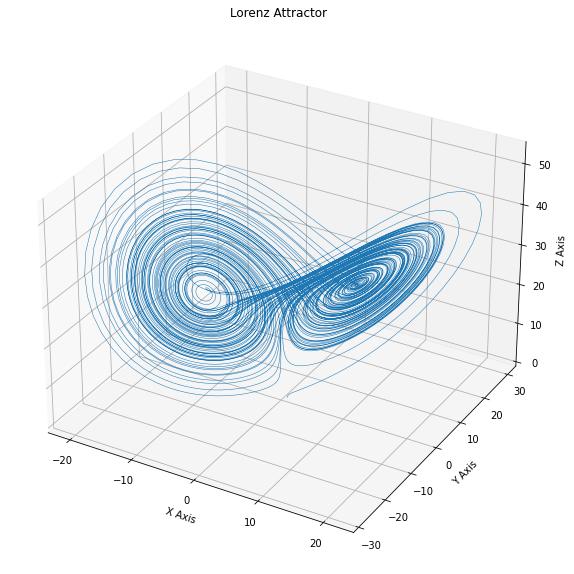

In [10]:
def lorenz(xyz, *, s=10, r=28, b=2.667):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

#does not work??
def tsucs(xyz, *, a=40, c=0.833, d=0.5, e=0.65, f=20):
    x, y, z = xyz
    x_dot = a*(y-x) + d*x*z
    y_dot = f*y - x*z
    z_dot = c*z + x*y - e*(x**2)
    return np.array([x_dot, y_dot, z_dot])

def halvorsen(xyzs, *, a=1.4):
    x, y, z = xyzs
    x_dot = -a*x - 4*y - 4*z - y**2
    y_dot = -a*y - 4*z - 4*x - z**2
    z_dot = -a*z - 4*x - 4*y - x**2
    return np.array([x_dot, y_dot, z_dot])
    


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))
# xyzs[0] = (0., 1., 1.05)
# xyzs[0] = (1., 1., 1.)
xyzs[0] = (1., 0, 0)


for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [11]:
#drawloop for points
def drawPointsIterativly(xyzs):
    imageList = []
    for iterator in range(len(xyzs[:4000])):
        fillBlack()
        
        #draw
        ctx.set_source_rgba(1.0,1.0,1.0, 1)

        pointsToDraw = []

        for x in range(len(xyzs[1:iterator])):
            pointsToDraw.append((xyzs[x], x))
        
        #sort by removed axis
        pointsToDraw.sort(key=lambda x: x[0][2])

        #drawLoop points
        for x in range(len(pointsToDraw)):
            ctx.set_source_rgba(1.0-pointsToDraw[x][1]/len(pointsToDraw),1.0-pointsToDraw[x][1]/len(pointsToDraw),1.0, 1)
            drawPoint(pointsToDraw[x][0])
            # drawLine(pointsToDraw[x-1], pointsToDraw[x])

        #rotate
        xyzs = rotatePoints(xyzs)


        imageList.append(to_pil(surface))
    return imageList

In [12]:
imageList = drawPointsIterativly(xyzs)
print(len(imageList))

4000


In [13]:
#drawloop for line
def drawLineIterativly(xyzs):
    imageList = []
    for iterator in range(len(xyzs[:4000])):
        fillBlack()
        
        #draw
        ctx.set_source_rgba(1.0,1.0,1.0, 1)

        pointsToDraw = []

        for x in range(len(xyzs[1:iterator])):
            pointsToDraw.append((xyzs[x-1], xyzs[x], x))
        
        #sort by removed axis
        pointsToDraw.sort(key=lambda x: (x[0][2] + x[1][2])/2)

        #drawLoop points
        for x in range(len(pointsToDraw)):
            ctx.set_source_rgba(1.0-pointsToDraw[x][2]/len(pointsToDraw),1.0-pointsToDraw[x][2]/len(pointsToDraw),1.0, 1)
            # drawPoint(pointsToDraw[x])
            drawLine(pointsToDraw[x][0], pointsToDraw[x][1])

        #rotate
        xyzs = rotatePoints(xyzs)


        imageList.append(to_pil(surface))
    return imageList

In [14]:
# imageList = drawLineIterativly(xyzs)
# print(len(imageList))

In [15]:
#drawloop for complete picture
def drawComplete(xyzs):
    imageList = []
    for iterator in range(1000):
        fillBlack()
        
        #draw
        ctx.set_source_rgba(1.0,1.0,1.0, 1)

        pointsToDraw = []

        for x in range(1, len(xyzs[:2500])):
            pointsToDraw.append((xyzs[x-1], xyzs[x], x))
        
        #sort by removed axis
        pointsToDraw.sort(key=lambda x: (x[0][2] + x[1][2])/2)

        #drawLoop points
        for x in range(len(pointsToDraw)):
            ctx.set_source_rgba(1.0-pointsToDraw[x][2]/len(pointsToDraw),1.0-pointsToDraw[x][2]/len(pointsToDraw),1.0, 1)
            drawPoint(pointsToDraw[x][0])
            # drawLine(pointsToDraw[x][0], pointsToDraw[x][1])

        #rotate
        xyzs = rotatePoints(xyzs)


        imageList.append(to_pil(surface))
    return imageList

In [16]:
# imageList = drawComplete(xyzs)
# print(len(imageList))

In [17]:
#Save as png
surface.write_to_png("images/LorenzAttractor.png")

In [18]:
# #Save as gif
# frame_one = imageList[0]
# frame_one.save("images/example.gif", format="GIF", append_images=imageList[0:5000],
#                save_all=True, duration=10, loop=0)

In [20]:
numberOfFrames = 720*4

video = cv2.VideoWriter("images/LorenzAttractor.mp4",-1,60,(1000,1000))

try:
    for i in range(numberOfFrames):
        video.write(cv2.cvtColor(np.array(imageList[i]), cv2.COLOR_RGB2BGR))
finally: 
    video.release()